<a href="https://colab.research.google.com/github/wai-ming-chan/fed_avg/blob/main/FedAvg_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo program to train MNIST with Pytorch (Federated Averging)

Reference: [https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029](https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029)

In [1]:
###############################
##### importing libraries #####
###############################

import os
import random
from tqdm import tqdm
import numpy as np
import math

import torch, torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset   
torch.backends.cudnn.benchmark=True

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

#-----------------------------------------------------------------------
# libraries for pyTorch model Visualization
! pip install -q torchview
! pip install -q -U graphviz

# import torchvision

from torchview import draw_graph
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')
#-----------------------------------------------------------------------
! pip install -q torch-summary
from torchsummary import summary
#--------------------------------------------
import pickle # library for save/load variable


### Hyper-parameters setting

In [2]:
class system_args:

    # Set GPU or CPU device. If GPU is available, we use it to speed up the training
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        print('[GPU mode] device: ', device)
    else:
        print('[CPU mode] device: ', device)
    verbose = 1

    num_clients = 100                     # Total number of clients
    num_rounds = 1200                      # number of communication rounds (num of server epoches)
    # bs = 64                               # batch size
    # epochs = 100                          
    lr = 250e-3                             # learning rate
    
    frac_C = 0        # C, fraction of clients that perform computation on each round
    local_epoches = 1  # E, number of training passes each client makes over its local dataset on each round
    local_bs = int(60000/num_clients)       # B, the local minibatch size used for the client updates.
    iid = True          # IID or Non-IID data partition 

    num_selected = int(max(math.ceil(frac_C * num_clients), 1))
    

[GPU mode] device:  cuda


### Helper functions for Federated Training

In [3]:
def client_update(client_model, optimizer, train_loader, system_args):
    model.train()   # tells your model that you are training the model (model.train()	vs model.eval())
    for e in range(system_args.local_epoches):
        for batch_idx, (data, target) in enumerate(train_loader):
            if system_args.device == 'cuda':
                data, target = data.cuda(), target.cuda()
            output = client_model(data)       # make a prediction
            loss = F.cross_entropy(output, target) # compute the loss value
            # loss = F.nll_loss(output, target) # compute the loss value
            # loss = F.nll_loss(output, target) # compute the loss value
            optimizer.zero_grad()             # set our gradient to zero
            loss.backward()                   # gradient descent
            optimizer.step()                  # update our weights and biases
    return loss.item()



def server_aggregate(global_model, client_models, system_args):
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)

    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict())


def test(global_model, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    model.eval()  # sets model in evaluation (inference) mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if system_args.device == 'cuda':
                data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       157,000
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       40,200
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0


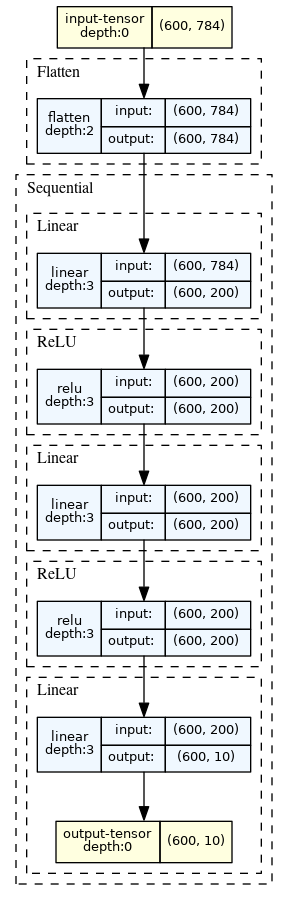

In [4]:
# setup our model now.

# Model 1: 2NN
class MNIST_2NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_2NN = MNIST_2NN().to(system_args.device)
summary(model_2NN, input_size=(1,28*28), batch_size=system_args.local_bs)

model_graph = draw_graph(
    model_2NN, 
    input_size=(bs,784), 
    graph_name='my2NN',
    hide_inner_tensors=True,
    hide_module_functions=False,
    expand_nested=True,
    roll=True, # rolls recursive models
    save_graph=True,
    filename="my2NN",
    directory="figs"
)
model_graph.visual_graph
#-----------------------------------------------------------------------

### Loading dataset


In [5]:
# grab MNIST data with torchvision datasets
## We can tell Pytorch how to manipulate the dataset by giving details.
##
### root: Where to store the data. We are storing it in data directory.
### train: Whether to grab training dataset or testing dataset. 
###         Given True value, training_data is a training dataset from MNIST. 
###         On the other hand, test_data is a testing dataset from MNIST.
### download: Whether to download if data is not already in root. We passed True to download the dataset.
### transform: What to do with data. We are converting our images of handwritten digits into Pytorch tensors so that we can train our model.

# Loading MNIST dataset using torchvision.datasets
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(
    training_data, 
    [int(training_data.data.shape[0] / system_args.num_clients) for _ in range(system_args.num_clients)]
)
    
# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=system_args.local_bs, shuffle=True) for x in traindata_split]

# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=system_args.local_bs, 
        shuffle=True
)


# check the dimension of data
print(training_data)
print('training data size: ', len(training_data) )
print('test data size: ', len(test_dataset) )
print(training_data[0][0].shape)
print(training_data[0][0].squeeze().shape)
# plt.imshow(training_data[len(training_data)-1][0].squeeze(), cmap="gray");
# print('label: ', training_data[len(training_data)-1][1])




Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
training data size:  60000
test data size:  10000
torch.Size([1, 28, 28])
torch.Size([28, 28])


### Training the model

In [6]:
############################################
#### Initializing models and optimizer  ####
############################################

#### global model ##########
# global_model =  VGG('VGG19').cuda()
global_model =  MNIST_2NN().to(system_args.device)

############## client models ##############
# client_models = [ VGG('VGG19').cuda() for _ in range(num_selected)]
client_models = [ MNIST_2NN().to(system_args.device) for _ in range(system_args.num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=system_args.lr) for model in client_models]

###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL

for r in range(system_args.num_rounds):
    # select random clients
    client_idx = np.random.permutation(system_args.num_clients)[:system_args.num_selected]
    # client update
    loss = 0
    # for i in tqdm(range(system_args.num_selected)):
    for i in range(system_args.num_selected):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], system_args)
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models, system_args)
    
    test_loss, acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
#     print('%d-th round' % r)
#     print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / system_args.num_selected, test_loss, acc))
    print('%3d-th round | average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (r, loss / system_args.num_selected, test_loss, acc))
    
    

  0-th round | average train loss 2.3 | test loss 2.29 | test acc: 0.152
  1-th round | average train loss 2.29 | test loss 2.28 | test acc: 0.210
  2-th round | average train loss 2.28 | test loss 2.28 | test acc: 0.264
  3-th round | average train loss 2.28 | test loss 2.27 | test acc: 0.318
  4-th round | average train loss 2.26 | test loss 2.26 | test acc: 0.325
  5-th round | average train loss 2.26 | test loss 2.24 | test acc: 0.391
  6-th round | average train loss 2.25 | test loss 2.23 | test acc: 0.404
  7-th round | average train loss 2.23 | test loss 2.22 | test acc: 0.399
  8-th round | average train loss 2.22 | test loss 2.2 | test acc: 0.394
  9-th round | average train loss 2.2 | test loss 2.18 | test acc: 0.390
 10-th round | average train loss 2.18 | test loss 2.16 | test acc: 0.406
 11-th round | average train loss 2.17 | test loss 2.13 | test acc: 0.466
 12-th round | average train loss 2.14 | test loss 2.1 | test acc: 0.458
 13-th round | average train loss 2.11 | t

110-th round | average train loss 0.334 | test loss 0.351 | test acc: 0.900
111-th round | average train loss 0.361 | test loss 0.35 | test acc: 0.902
112-th round | average train loss 0.433 | test loss 0.349 | test acc: 0.899
113-th round | average train loss 0.378 | test loss 0.345 | test acc: 0.903
114-th round | average train loss 0.336 | test loss 0.352 | test acc: 0.898
115-th round | average train loss 0.392 | test loss 0.354 | test acc: 0.901
116-th round | average train loss 0.364 | test loss 0.346 | test acc: 0.900
117-th round | average train loss 0.319 | test loss 0.343 | test acc: 0.902
118-th round | average train loss 0.353 | test loss 0.344 | test acc: 0.899
119-th round | average train loss 0.342 | test loss 0.354 | test acc: 0.895
120-th round | average train loss 0.369 | test loss 0.367 | test acc: 0.892
121-th round | average train loss 0.416 | test loss 0.389 | test acc: 0.877
122-th round | average train loss 0.429 | test loss 0.411 | test acc: 0.871
123-th round 

219-th round | average train loss 0.229 | test loss 0.26 | test acc: 0.923
220-th round | average train loss 0.315 | test loss 0.263 | test acc: 0.923
221-th round | average train loss 0.251 | test loss 0.262 | test acc: 0.924
222-th round | average train loss 0.268 | test loss 0.263 | test acc: 0.923
223-th round | average train loss 0.258 | test loss 0.26 | test acc: 0.926
224-th round | average train loss 0.206 | test loss 0.258 | test acc: 0.925
225-th round | average train loss 0.279 | test loss 0.261 | test acc: 0.925
226-th round | average train loss 0.26 | test loss 0.263 | test acc: 0.923
227-th round | average train loss 0.258 | test loss 0.259 | test acc: 0.926
228-th round | average train loss 0.247 | test loss 0.258 | test acc: 0.924
229-th round | average train loss 0.264 | test loss 0.259 | test acc: 0.926
230-th round | average train loss 0.226 | test loss 0.255 | test acc: 0.926
231-th round | average train loss 0.226 | test loss 0.262 | test acc: 0.923
232-th round | 

328-th round | average train loss 0.205 | test loss 0.22 | test acc: 0.937
329-th round | average train loss 0.252 | test loss 0.216 | test acc: 0.938
330-th round | average train loss 0.234 | test loss 0.22 | test acc: 0.933
331-th round | average train loss 0.226 | test loss 0.218 | test acc: 0.937
332-th round | average train loss 0.215 | test loss 0.223 | test acc: 0.936
333-th round | average train loss 0.219 | test loss 0.225 | test acc: 0.935
334-th round | average train loss 0.247 | test loss 0.215 | test acc: 0.935
335-th round | average train loss 0.226 | test loss 0.212 | test acc: 0.938
336-th round | average train loss 0.216 | test loss 0.208 | test acc: 0.939
337-th round | average train loss 0.236 | test loss 0.211 | test acc: 0.939
338-th round | average train loss 0.223 | test loss 0.215 | test acc: 0.936
339-th round | average train loss 0.241 | test loss 0.215 | test acc: 0.938
340-th round | average train loss 0.231 | test loss 0.209 | test acc: 0.939
341-th round |

437-th round | average train loss 0.176 | test loss 0.182 | test acc: 0.947
438-th round | average train loss 0.139 | test loss 0.181 | test acc: 0.947
439-th round | average train loss 0.219 | test loss 0.187 | test acc: 0.945
440-th round | average train loss 0.144 | test loss 0.185 | test acc: 0.944
441-th round | average train loss 0.223 | test loss 0.193 | test acc: 0.944
442-th round | average train loss 0.164 | test loss 0.182 | test acc: 0.947
443-th round | average train loss 0.159 | test loss 0.195 | test acc: 0.942
444-th round | average train loss 0.238 | test loss 0.186 | test acc: 0.943
445-th round | average train loss 0.171 | test loss 0.181 | test acc: 0.947
446-th round | average train loss 0.19 | test loss 0.18 | test acc: 0.947
447-th round | average train loss 0.175 | test loss 0.183 | test acc: 0.946
448-th round | average train loss 0.196 | test loss 0.184 | test acc: 0.944
449-th round | average train loss 0.183 | test loss 0.19 | test acc: 0.944
450-th round | 

546-th round | average train loss 0.12 | test loss 0.162 | test acc: 0.952
547-th round | average train loss 0.114 | test loss 0.159 | test acc: 0.952
548-th round | average train loss 0.197 | test loss 0.168 | test acc: 0.951
549-th round | average train loss 0.184 | test loss 0.165 | test acc: 0.951
550-th round | average train loss 0.188 | test loss 0.167 | test acc: 0.950
551-th round | average train loss 0.148 | test loss 0.16 | test acc: 0.953
552-th round | average train loss 0.166 | test loss 0.16 | test acc: 0.952
553-th round | average train loss 0.113 | test loss 0.159 | test acc: 0.952
554-th round | average train loss 0.236 | test loss 0.169 | test acc: 0.948
555-th round | average train loss 0.146 | test loss 0.16 | test acc: 0.952
556-th round | average train loss 0.15 | test loss 0.156 | test acc: 0.953
557-th round | average train loss 0.15 | test loss 0.162 | test acc: 0.951
558-th round | average train loss 0.169 | test loss 0.165 | test acc: 0.951
559-th round | ave

654-th round | average train loss 0.17 | test loss 0.153 | test acc: 0.954
655-th round | average train loss 0.131 | test loss 0.146 | test acc: 0.957
656-th round | average train loss 0.15 | test loss 0.147 | test acc: 0.956
657-th round | average train loss 0.0928 | test loss 0.148 | test acc: 0.955
658-th round | average train loss 0.138 | test loss 0.147 | test acc: 0.956
659-th round | average train loss 0.16 | test loss 0.152 | test acc: 0.953
660-th round | average train loss 0.152 | test loss 0.146 | test acc: 0.954
661-th round | average train loss 0.114 | test loss 0.145 | test acc: 0.954
662-th round | average train loss 0.182 | test loss 0.147 | test acc: 0.955
663-th round | average train loss 0.118 | test loss 0.146 | test acc: 0.954
664-th round | average train loss 0.167 | test loss 0.15 | test acc: 0.955
665-th round | average train loss 0.2 | test loss 0.163 | test acc: 0.950
666-th round | average train loss 0.185 | test loss 0.153 | test acc: 0.954
667-th round | av

762-th round | average train loss 0.133 | test loss 0.129 | test acc: 0.960
763-th round | average train loss 0.115 | test loss 0.131 | test acc: 0.960
764-th round | average train loss 0.151 | test loss 0.13 | test acc: 0.960
765-th round | average train loss 0.152 | test loss 0.135 | test acc: 0.959
766-th round | average train loss 0.113 | test loss 0.129 | test acc: 0.960
767-th round | average train loss 0.137 | test loss 0.13 | test acc: 0.960
768-th round | average train loss 0.15 | test loss 0.137 | test acc: 0.958
769-th round | average train loss 0.101 | test loss 0.13 | test acc: 0.960
770-th round | average train loss 0.115 | test loss 0.128 | test acc: 0.960
771-th round | average train loss 0.0981 | test loss 0.128 | test acc: 0.960
772-th round | average train loss 0.0983 | test loss 0.128 | test acc: 0.960
773-th round | average train loss 0.129 | test loss 0.136 | test acc: 0.960
774-th round | average train loss 0.145 | test loss 0.129 | test acc: 0.959
775-th round |

870-th round | average train loss 0.0851 | test loss 0.122 | test acc: 0.962
871-th round | average train loss 0.131 | test loss 0.123 | test acc: 0.962
872-th round | average train loss 0.124 | test loss 0.121 | test acc: 0.964
873-th round | average train loss 0.1 | test loss 0.118 | test acc: 0.964
874-th round | average train loss 0.0755 | test loss 0.119 | test acc: 0.964
875-th round | average train loss 0.0974 | test loss 0.12 | test acc: 0.963
876-th round | average train loss 0.109 | test loss 0.125 | test acc: 0.961
877-th round | average train loss 0.117 | test loss 0.12 | test acc: 0.963
878-th round | average train loss 0.124 | test loss 0.127 | test acc: 0.962
879-th round | average train loss 0.0922 | test loss 0.121 | test acc: 0.962
880-th round | average train loss 0.095 | test loss 0.119 | test acc: 0.963
881-th round | average train loss 0.077 | test loss 0.119 | test acc: 0.962
882-th round | average train loss 0.119 | test loss 0.126 | test acc: 0.962
883-th round

978-th round | average train loss 0.151 | test loss 0.116 | test acc: 0.965
979-th round | average train loss 0.128 | test loss 0.11 | test acc: 0.966
980-th round | average train loss 0.0779 | test loss 0.109 | test acc: 0.966
981-th round | average train loss 0.119 | test loss 0.115 | test acc: 0.966
982-th round | average train loss 0.0818 | test loss 0.108 | test acc: 0.966
983-th round | average train loss 0.125 | test loss 0.117 | test acc: 0.965
984-th round | average train loss 0.106 | test loss 0.11 | test acc: 0.966
985-th round | average train loss 0.0802 | test loss 0.11 | test acc: 0.965
986-th round | average train loss 0.112 | test loss 0.11 | test acc: 0.966
987-th round | average train loss 0.101 | test loss 0.11 | test acc: 0.967
988-th round | average train loss 0.0929 | test loss 0.11 | test acc: 0.967
989-th round | average train loss 0.108 | test loss 0.113 | test acc: 0.964
990-th round | average train loss 0.0951 | test loss 0.11 | test acc: 0.966
991-th round |

1085-th round | average train loss 0.0922 | test loss 0.11 | test acc: 0.967
1086-th round | average train loss 0.115 | test loss 0.106 | test acc: 0.967
1087-th round | average train loss 0.076 | test loss 0.105 | test acc: 0.967
1088-th round | average train loss 0.0776 | test loss 0.102 | test acc: 0.966
1089-th round | average train loss 0.0729 | test loss 0.104 | test acc: 0.966
1090-th round | average train loss 0.0966 | test loss 0.109 | test acc: 0.965
1091-th round | average train loss 0.0839 | test loss 0.103 | test acc: 0.968
1092-th round | average train loss 0.0659 | test loss 0.105 | test acc: 0.968
1093-th round | average train loss 0.0859 | test loss 0.104 | test acc: 0.967
1094-th round | average train loss 0.0858 | test loss 0.103 | test acc: 0.967
1095-th round | average train loss 0.0651 | test loss 0.104 | test acc: 0.965
1096-th round | average train loss 0.0861 | test loss 0.104 | test acc: 0.968
1097-th round | average train loss 0.097 | test loss 0.103 | test a

1191-th round | average train loss 0.0988 | test loss 0.0986 | test acc: 0.968
1192-th round | average train loss 0.0579 | test loss 0.0976 | test acc: 0.969
1193-th round | average train loss 0.0458 | test loss 0.0987 | test acc: 0.969
1194-th round | average train loss 0.0746 | test loss 0.102 | test acc: 0.969
1195-th round | average train loss 0.0649 | test loss 0.0992 | test acc: 0.970
1196-th round | average train loss 0.0908 | test loss 0.103 | test acc: 0.967
1197-th round | average train loss 0.11 | test loss 0.107 | test acc: 0.967
1198-th round | average train loss 0.118 | test loss 0.104 | test acc: 0.968
1199-th round | average train loss 0.0591 | test loss 0.101 | test acc: 0.968


In [7]:
# Saving the objects:
with open('figs/MNIST_2NN_FedSGD.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([
        losses_train, 
        losses_test,
        acc_test], 
        f
    )

### Some model hyperparameters setting

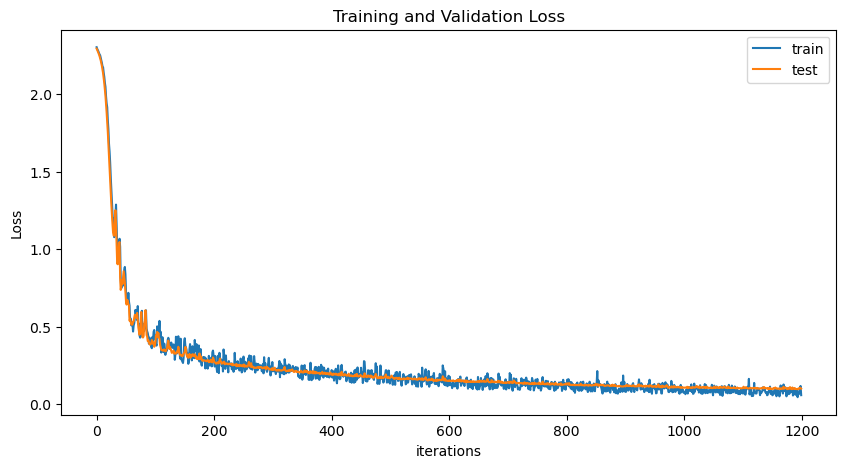

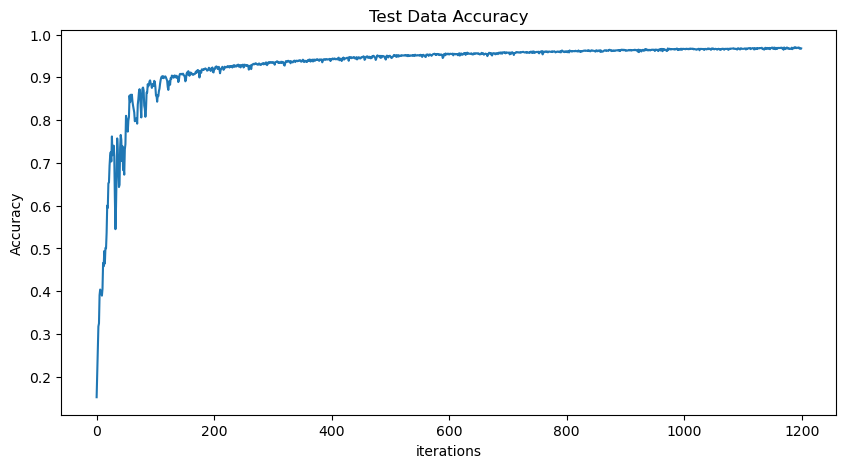

In [8]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(losses_train,label="train")
plt.plot(losses_test,label="test")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('figs/FedSGD_Loss.png')
plt.show()

plt.figure(figsize=(10,5))
plt.title("Test Data Accuracy")
# plt.plot(acc_train,label="train")
plt.plot(acc_test,label="test")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.savefig('figs/FedSGD_Accuracy.png')
# plt.legend()
plt.show()

